# Storing data effectively

At this point, you should be comfortable with using base Pandas operators to select columns and select rows from a dataframe.

In this lesson, we will use microdata from the ENEM 2022 exam. Run the code below to unzip and download the data:

In [65]:
import requests 
import zipfile 
import pandas as pd 
import os
from tqdm import tqdm

def download_data():
    if not os.path.exists('microdados_enem_2022.zip'):
        print("File does not exist. Downloading now...")
    else:
        print("File already exists.")
        return True
        
    url = 'https://download.inep.gov.br/microdados/microdados_enem_2022.zip'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0'}
    response = requests.get(url, stream=True, headers=headers)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024

    with open('microdados_enem_2022.zip', 'wb') as file:
        for data in tqdm(response.iter_content(block_size), total=total_size//block_size, unit='KB', unit_scale=True):
            file.write(data)
    
    return True

def unzip_data():
    if not os.path.exists('microdados_enem_2022.csv'):
        print("Unzipping the required file...")
    else:
        print("File already unzipped.")
        return True

    with zipfile.ZipFile('microdados_enem_2022.zip', 'r') as zip_ref:
        zip_ref.extract('DADOS/MICRODADOS_ENEM_2022.csv')
    os.rename('DADOS/MICRODADOS_ENEM_2022.csv', 'microdados_enem_2022.csv')
    return True

download_data()
unzip_data()


File already exists.
File already unzipped.


True

Trying to open this whole dataset can exceed your memory. Use `htop` and watch what happens when you try to execute this:

In [66]:
#%timeit
#df = pd.read_csv('microdados_enem_2022.csv', sep=';', decimal=',', encoding='latin1')

In [95]:
import sqlite3

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('my_database.db')
cursor = conn.cursor()

# Read CSV in chunks and insert into database
chunk_size = 10000
for chunk in tqdm(pd.read_csv('microdados_enem_2022.csv', sep=';', decimal=',', encoding='latin1', chunksize=chunk_size)):
    # I will use this preprocessing feature later!
    chunk = chunk[chunk['CO_MUNICIPIO_ESC'].notnull()]
    chunk.loc[:,'CO_MUNICIPIO_ESC'] = chunk['CO_MUNICIPIO_ESC'].apply(lambda x: int(str(x).split('.')[0][:-1])) # Remove last digit from CO_MUNICIPIO_ESC
    chunk.to_sql('enem_data', conn, if_exists='append', index=False)

# Commit and close connection
conn.commit()
conn.close()

0it [00:00, ?it/s]

348it [01:14,  4.64it/s]


## View database info

## View tables in a database

In [96]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('my_database.db')
cursor = conn.cursor()

# Execute query to list tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch and print the list of tables
tables = cursor.fetchall()
print(tables)

# Close the connection
conn.close()

[('enem_data',)]


## View columns in a table

In [97]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('my_database.db')
cursor = conn.cursor()

# Execute query to list columns in the enem_data table
cursor.execute("PRAGMA table_info(enem_data);")

# Fetch and print the list of columns
columns = cursor.fetchall()
print([column[1] for column in columns])

# Close the connection
conn.close()

['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TP_LINGUA', 'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC', 'TX_GABARITO_MT', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 

## Types of queries


### Queries and operations

In [3]:
query = """
SELECT 
    CO_MUNICIPIO_ESC,
    NO_MUNICIPIO_ESC,
    NU_NOTA_MT,
    (NU_NOTA_CN + NU_NOTA_CH + NU_NOTA_LC + NU_NOTA_MT)/4 AS NU_NOTA_TOTAL
FROM 
    enem_data
WHERE
    TP_ESCOLA = 2 AND
    TP_DEPENDENCIA_ADM_ESC = 2
ORDER BY
    NU_NOTA_TOTAL DESC
LIMIT 10;
"""

In [4]:
# Method 1: Using sqlite3 module
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('my_database.db')
cursor = conn.cursor()

# Execute query to list columns in the enem_data table
cursor.execute(query)

# Fetch and print the query results
results = cursor.fetchall()
for row in results:
    print(row)
    
# Close the connection
conn.close()

(520860.0, 'Goianésia', '944.2', 788.0999999999999)
(230945.0, 'Ocara', '940.7', 777.175)
(430610.0, 'Cruz Alta', '843.3', 774.1500000000001)
(431020.0, 'Ijuí', '930.7', 770.7749999999999)
(420120.0, 'Antônio Carlos', '952.4', 770.1)
(530010.0, 'Brasília', '871.7', 766.625)
(261160.0, 'Recife', '876.6', 765.4499999999999)
(431020.0, 'Ijuí', '920.5', 763.45)
(431490.0, 'Porto Alegre', '915.1', 762.875)
(230440.0, 'Fortaleza', '887.5', 761.025)


In [5]:
# Method 2: Using pandas
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect('my_database.db')

# Execute query using pandas
df = pd.read_sql_query(query, conn)

print(df)

   CO_MUNICIPIO_ESC NO_MUNICIPIO_ESC NU_NOTA_MT  NU_NOTA_TOTAL
0          520860.0        Goianésia      944.2        788.100
1          230945.0            Ocara      940.7        777.175
2          430610.0        Cruz Alta      843.3        774.150
3          431020.0             Ijuí      930.7        770.775
4          420120.0   Antônio Carlos      952.4        770.100
5          530010.0         Brasília      871.7        766.625
6          261160.0           Recife      876.6        765.450
7          431020.0             Ijuí      920.5        763.450
8          431490.0     Porto Alegre      915.1        762.875
9          230440.0        Fortaleza      887.5        761.025


### Aggregating results with MEAN

In [6]:
query = """
SELECT 
    CO_MUNICIPIO_ESC,
    NO_MUNICIPIO_ESC,
    NU_NOTA_MT,
    AVG((NU_NOTA_CN + NU_NOTA_CH + NU_NOTA_LC + NU_NOTA_MT)/4) AS NU_NOTA_TOTAL
FROM 
    enem_data
WHERE
    TP_ESCOLA = 2 AND
    TP_DEPENDENCIA_ADM_ESC = 2
GROUP BY
    CO_MUNICIPIO_ESC
ORDER BY
    NU_NOTA_TOTAL DESC
LIMIT 10;
"""

conn = sqlite3.connect('my_database.db')
df = pd.read_sql_query(query, conn)
print(df)

   CO_MUNICIPIO_ESC      NO_MUNICIPIO_ESC NU_NOTA_MT  NU_NOTA_TOTAL
0          311720.0  Conceição das Pedras      794.3     648.300000
1          312990.0     Ibitiúra de Minas      671.9     631.050000
2          521480.0           Nova Aurora      717.5     620.475000
3          411160.0               Ivatuba      609.6     612.025000
4          350395.0               Aspásia      683.4     604.800000
5          431190.0       Marcelino Ramos      665.4     603.212500
6          310700.0             Biquinhas      661.3     600.700000
7          314053.0        Martins Soares       None     600.606250
8          430720.0          Erval Grande       None     593.216667
9          350110.0           Alto Alegre      700.4     592.975000


### Using intermediate results

In [7]:
query = """
WITH MEAN_GRADES AS (
    SELECT 
        CO_MUNICIPIO_ESC,
        NO_MUNICIPIO_ESC,
        NU_NOTA_MT,
        AVG((NU_NOTA_CN + NU_NOTA_CH + NU_NOTA_LC + NU_NOTA_MT)/4) AS NU_NOTA_TOTAL
    FROM 
        enem_data
    WHERE
        TP_ESCOLA = 2 AND
        TP_DEPENDENCIA_ADM_ESC = 2
    GROUP BY
        CO_MUNICIPIO_ESC
    ORDER BY
        NU_NOTA_TOTAL DESC
    LIMIT 10
)

SELECT
    *
FROM
    MEAN_GRADES
WHERE
    NU_NOTA_TOTAL > 540;
"""

conn = sqlite3.connect('my_database.db')
df = pd.read_sql_query(query, conn)
print(df)

   CO_MUNICIPIO_ESC      NO_MUNICIPIO_ESC NU_NOTA_MT  NU_NOTA_TOTAL
0          311720.0  Conceição das Pedras      794.3     648.300000
1          312990.0     Ibitiúra de Minas      671.9     631.050000
2          521480.0           Nova Aurora      717.5     620.475000
3          411160.0               Ivatuba      609.6     612.025000
4          350395.0               Aspásia      683.4     604.800000
5          431190.0       Marcelino Ramos      665.4     603.212500
6          310700.0             Biquinhas      661.3     600.700000
7          314053.0        Martins Soares       None     600.606250
8          430720.0          Erval Grande       None     593.216667
9          350110.0           Alto Alegre      700.4     592.975000


## Dealing with multiple tables

In [103]:
import pandas as pd
df = pd.read_csv(
    'data.csv',
    sep=';',
    decimal=',',
    skiprows=3,
    skipfooter=11,
    engine='python',
)
df['COD_MUNICIPIO'] = df['Município'].apply(lambda x : x.split(sep=' ', maxsplit=1)[0])

conn = sqlite3.connect('my_database.db')
cursor = conn.cursor()
df.to_sql('gdp_per_capita', conn, if_exists='replace', index=False)
conn.commit()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(tables)


[('enem_data',), ('gdp_per_capita',)]


### A query with "join"

In [9]:
query = """
SELECT 
    enem_data.CO_MUNICIPIO_ESC,
    enem_data.NO_MUNICIPIO_ESC,
    enem_data.SG_UF_ESC,
    gdp_per_capita.PIB_per_capita,
    AVG((enem_data.NU_NOTA_CN + enem_data.NU_NOTA_CH + enem_data.NU_NOTA_LC + enem_data.NU_NOTA_MT)/4) AS NU_NOTA_TOTAL
FROM 
    enem_data JOIN gdp_per_capita ON enem_data.CO_MUNICIPIO_ESC = gdp_per_capita.COD_MUNICIPIO
WHERE
    enem_data.TP_ESCOLA = 2 AND
    enem_data.TP_DEPENDENCIA_ADM_ESC = 2
GROUP BY
    enem_data.CO_MUNICIPIO_ESC
ORDER BY
    NU_NOTA_TOTAL DESC
"""

conn = sqlite3.connect('my_database.db')
df = pd.read_sql_query(query, conn)
print(df)

     CO_MUNICIPIO_ESC     NO_MUNICIPIO_ESC SG_UF_ESC  PIB_per_capita  \
0            350395.0              Aspásia        SP        11055.89   
1            350110.0          Alto Alegre        SP        17363.72   
2            354610.0  Santa Clara d'Oeste        SP        21471.68   
3            355465.0       Torre de Pedra        SP        10040.78   
4            350230.0              Anhembi        SP        17558.27   
..                ...                  ...       ...             ...   
634          351810.0             Guarantã        SP        17143.27   
635          351800.0      Guarani d'Oeste        SP        12624.12   
636          351420.0         Dolcinópolis        SP        14735.86   
637          351250.0             Coroados        SP        17846.43   
638          350180.0    Américo de Campos        SP        11728.86   

     NU_NOTA_TOTAL  
0          604.800  
1          592.975  
2          591.275  
3          580.450  
4          570.300  
..       

Correlation coefficient: 0.16731463773154814 (p-value: 2.6599083248557167e-05)


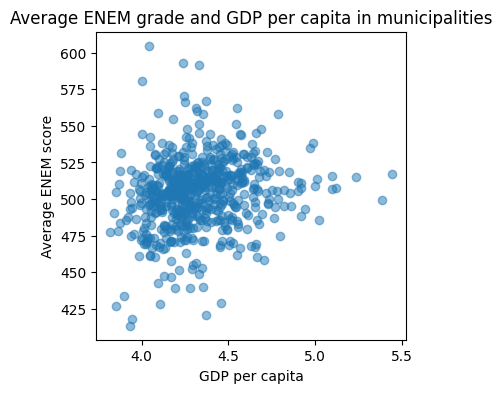

In [11]:
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
df = df.dropna(subset=['NU_NOTA_TOTAL'])
x = np.log10(df['PIB_per_capita'])
y = df['NU_NOTA_TOTAL']
uf = df['SG_UF_ESC']
r, p = st.pearsonr(x, y)
print(f"Correlation coefficient: {r} (p-value: {p})")
plt.figure(figsize=(4, 4))
plt.scatter(x, y, alpha=0.5)
plt.xlabel('GDP per capita')
plt.ylabel('Average ENEM score')
plt.title('Average ENEM grade and GDP per capita in municipalities')
plt.show()

## Review and exercises

At this point, you should have used:

* SQL queries
* Aggregation operators
* Intermediate results
* Join

Now, let's proceed to some exercises:

In [ ]:
# Challenge 1
# Using a SQL query, find the average total score of students who attended public schools (TP_ESCOLA = 2) 
# and private schools (TP_ESCOLA = 3) in the state of São Paulo (SG_UF_ESC = 'SP').


In [ ]:
# Challenge 2
# Using a SQL query, find the average total score of students who attended public schools (TP_ESCOLA = 2) 
# and private schools (TP_ESCOLA = 3) in the 10 wealthiest cities state of São Paulo.

In [ ]:
# Challenge 3
# Using a SQL query, find the average total score of students who attended state, federal, and city public schools (TP_ESCOLA = 2)

In [ ]:
# Challenge 4
# Using a SQL query, find the average GDP of the 10 cities with the highest average total score of students who attended public schools
# (TP_ESCOLA = 2)


In [ ]:
# Challenge 5
# Using a SQL query, find which are the three states with higher average total 
# score of students who attended state public schools (TP_ESCOLA = 2, TP_DEPENDENCIA_ADM_ESC = 2)


In [ ]:
# Challenge 6
# Get data from ENEM 2023 and check if the three states with higher average total score of students who attended state public schools (TP_ESCOLA = 2, TP_DEPENDENCIA_ADM_ESC = 2)
# are the same as in 2022. If not, what are the differences?


In [ ]:
# Challenge 7
# Get data from DataSUS and check if there is a correlation between the illiteracy rates in each city and the 
# average total score of students who attended public schools in that city.
